# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
#%matplotlib qt
%qtconsole

## Helper Functions

In [74]:
#**Helper Function for Camera Calibration**
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#**Helper function for color and gradient thresholds**
#Takes in threshold for HLS color space and for sobel in the x direction 
def sobel_grad_thresh(img, s_thresh=(170, 255), l_thresh =(170,255), sx_thresh=(20, 100),sobel_kernel=3):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #Aaron added l to look at light space
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    #Now only take sobelx if it overlaps with 
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, l_binary)) * 255
    return color_binary

## Camera Calibration

### Reading in a chessboard image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


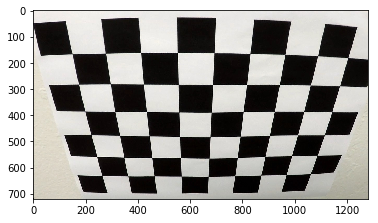

In [3]:
#Reading in a chessboard image example
img = mpimg.imread('camera_cal/calibration2.jpg')
#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')



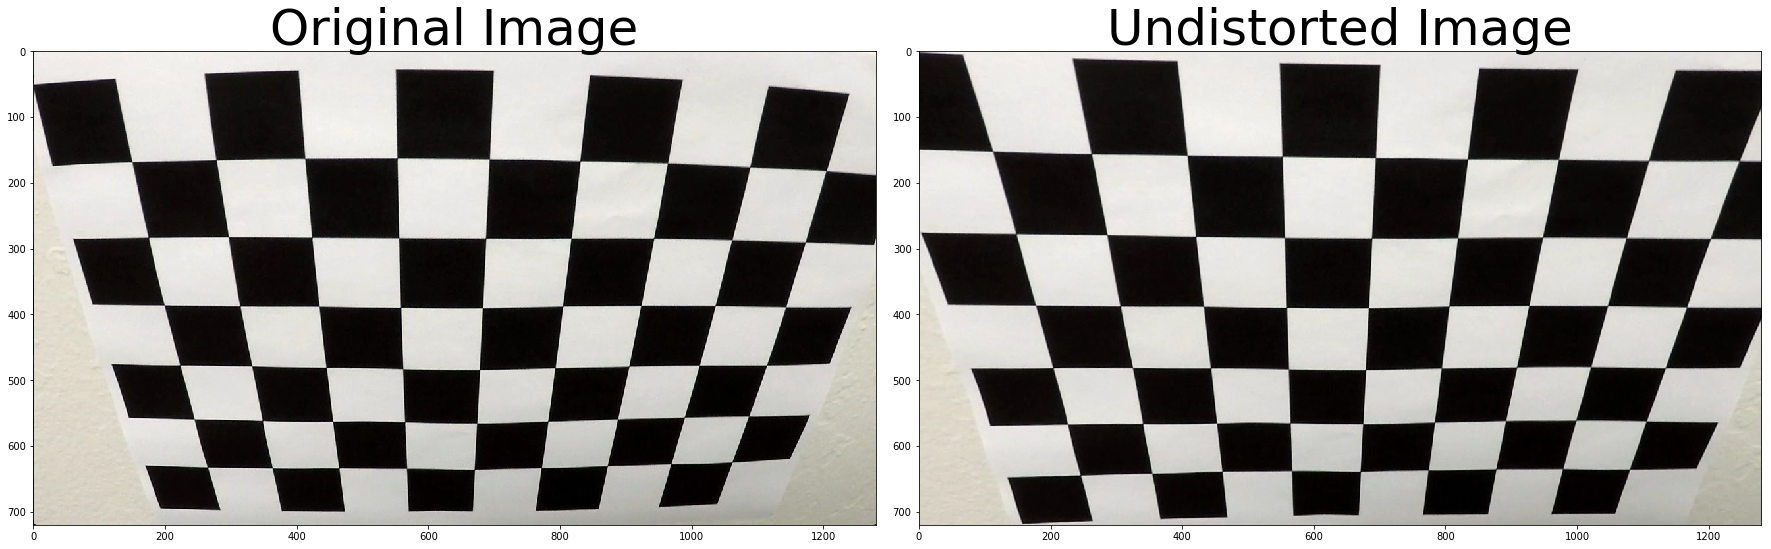

In [4]:
# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space (range from [0,0,0] to [8,5,0] )
imgpoints = [] # 2D points in image plane

#Prepare object points, like (0,0,0), (1,0,0)...(8,5,0)
objp =np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x,y coordinates

for fname in images:
    #Read in each image
    img = mpimg.imread(fname)

    #Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #if the corners are found, add oject points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display the corners
        img = cv2.drawChessboardCorners(img,(9,6), corners, ret)
        #plt.imshow(img)
        #plt.title("Chessboard Corners on Raw Image")
        #plt.savefig('output_images/ChessCornersRaw')
        #plt.show()

# Read in the chess board image and test the undistort
img = mpimg.imread('camera_cal/calibration2.jpg')
#Use the collection of object points and image points from all our chessboard pics to calibrate the camera
undistorted = cal_undistort(img, objpoints, imgpoints)
#Plot the origional and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('output_images/OrigionalVsUndistortedImage')
plt.show()


## Pipeline (Single Images)

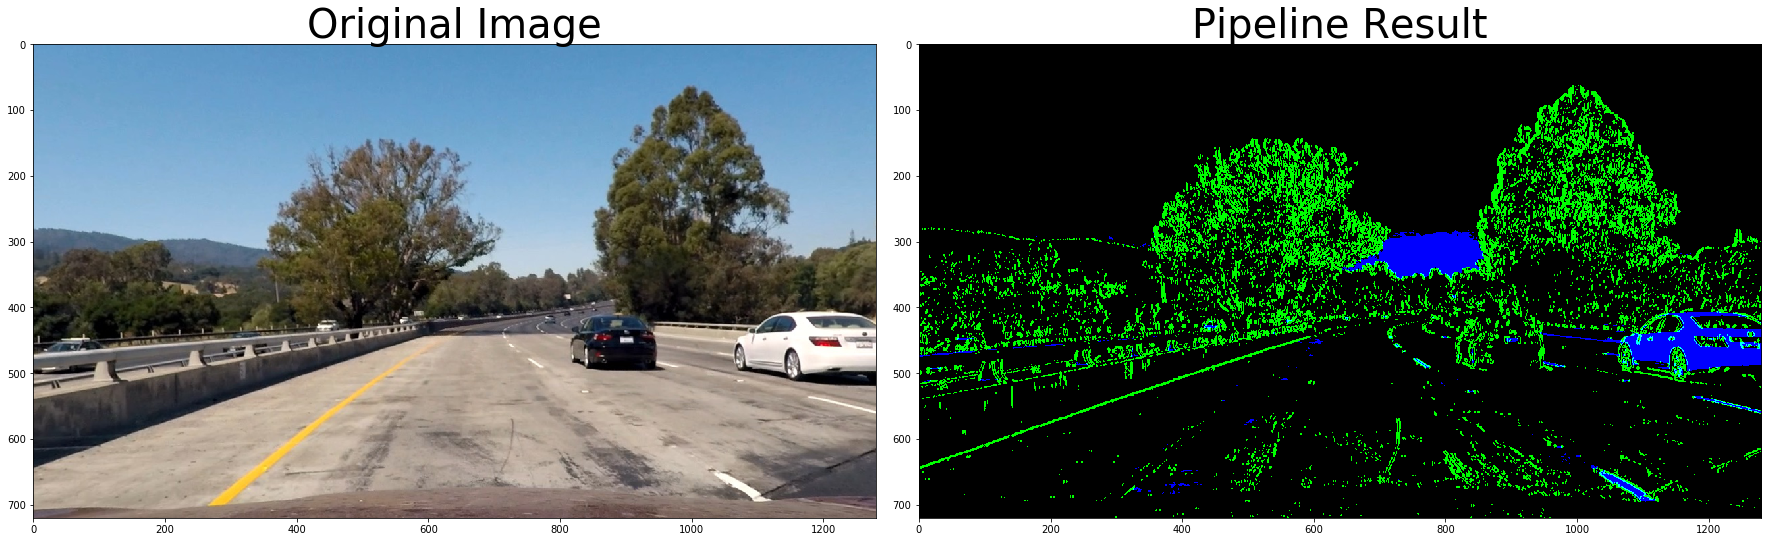

In [101]:
#Step 1- distortion correction
#Now read in a road test image and test the undistort
img = mpimg.imread('test_images/test1.jpg')
#Use the collection of object points and image points from all our chessboard pics to calibrate the camera
undistorted = cal_undistort(img, objpoints, imgpoints)
''' #Uncomment this section to plot for report
#Plot the origional and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('output_images/OrigionalVsUndistortedImage_road')
plt.show()
'''

#Step 2- Combined Colo and gradient  threshold for lane detection
#In output, green = Sobel and Blue = HLS -S thresh (150,255) Sx=(15,100)
result = sobel_grad_thresh(undistorted, s_thresh=(150, 255),l_thresh=(199, 255), sx_thresh=(15, 100),sobel_kernel=5)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)